##Implement Otsu’s thresholding, watershed algorithm and K Means.

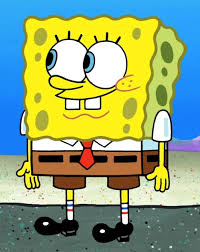

Original Image


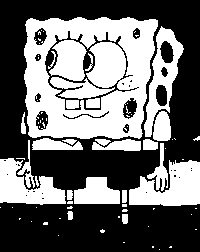

Otsu Thresholding


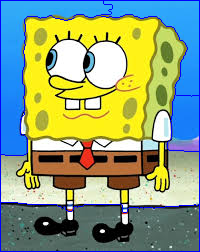

Watershed Segmentation


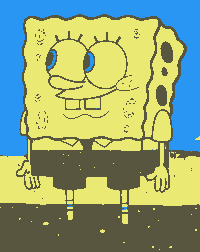

K-Means Segmentation


In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def otsu_threshold(image):
    hist, bins = np.histogram(image.ravel(), 256, [0, 256])
    total_pixels = image.size
    current_max, threshold = 0, 0
    sum_total, sum_background = 0, 0
    weight_background, weight_foreground = 0, 0

    for i in range(256):
        sum_total += i * hist[i]

    for i in range(256):
        weight_background += hist[i]
        if weight_background == 0:
            continue
        weight_foreground = total_pixels - weight_background
        if weight_foreground == 0:
            break
        sum_background += i * hist[i]
        mean_background = sum_background / weight_background
        mean_foreground = (sum_total - sum_background) / weight_foreground
        between_class_variance = weight_background * weight_foreground * (mean_background - mean_foreground) ** 2
        if between_class_variance > current_max:
            current_max = between_class_variance
            threshold = i
    binary_image = (image > threshold).astype(np.uint8) * 255
    return threshold, binary_image

def watershed_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]
    return image

def kmeans_segmentation(image, K=3):
    Z = image.reshape((-1, 3))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    return res.reshape((image.shape))

def visualize_results(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    otsu_thresh, binary_image = otsu_threshold(gray)
    watershed_result = watershed_segmentation(image.copy())
    kmeans_result = kmeans_segmentation(image.copy(), K=3)

    cv2_imshow(image)
    print("Original Image")
    cv2_imshow(binary_image)
    print("Otsu Thresholding")
    cv2_imshow(watershed_result)
    print("Watershed Segmentation")
    cv2_imshow(kmeans_result)
    print("K-Means Segmentation")

# Load image
image = cv2.imread("/content/download.jpeg")
visualize_results(image)

##Comparison

1. Otsu’s thresholding is a simple and fast method. It works well for images with a clear foreground and background. However, it fails when lighting conditions vary or when there are multiple objects. It is best for binary segmentation tasks like document processing.  

2. The watershed algorithm is useful for separating touching objects. It treats the image like a topographic map and finds object boundaries. However, it can cause over-segmentation if not handled properly. It is ideal for medical imaging and object detection.  

3. K-Means segmentation groups pixels based on color or intensity. It works well for multi-class segmentation. However, choosing the right number of clusters (\( K \)) is tricky. It struggles with images having non-uniform lighting. It is good for background removal and texture segmentation.